# **Main functions and classes**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym
import gym_2048
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import collections

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Using cuda to accelerate training

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
device = torch.device(device)
    
print("PyTorch is using :", device)

PyTorch is using : mps


In [4]:
class DQN(nn.Module):
    ### Deep Q-Learning Network
    def __init__(self):
        super(DQN, self).__init__()
        
        self.conv_a = nn.Conv2d(16, 128, kernel_size=(1,2))        # Convolutional layers
        self.conv_b = nn.Conv2d(16, 128, kernel_size=(2,1))

        self.conv_aa = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_ab = nn.Conv2d(128, 128, kernel_size=(2,1))

        self.conv_ba = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_bb = nn.Conv2d(128, 128, kernel_size=(2,1))
        
        self.fc = nn.Sequential(         # Linear and Relu
            nn.Linear(7424, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
        
    def forward(self, x):
      # Forward function of the layer
        x_a = F.relu(self.conv_a(x))
        x_b = F.relu(self.conv_b(x))
        
        x_aa = F.relu(self.conv_aa(x_a))
        x_ab = F.relu(self.conv_ab(x_a))
        
        x_ba = F.relu(self.conv_ba(x_b))
        x_bb = F.relu(self.conv_bb(x_b))
        
        sh_a = x_a.shape
        sh_aa = x_aa.shape
        sh_ab = x_ab.shape
        sh_b = x_b.shape
        sh_ba = x_ba.shape
        sh_bb = x_bb.shape
        
        x_a = x_a.view(sh_a[0],sh_a[1]*sh_a[2]*sh_a[3])
        x_aa = x_aa.view(sh_aa[0],sh_aa[1]*sh_aa[2]*sh_aa[3])
        x_ab = x_ab.view(sh_ab[0],sh_ab[1]*sh_ab[2]*sh_ab[3])
        x_b = x_b.view(sh_b[0],sh_b[1]*sh_b[2]*sh_b[3])
        x_ba = x_ba.view(sh_ba[0],sh_ba[1]*sh_ba[2]*sh_ba[3])
        x_bb = x_bb.view(sh_bb[0],sh_bb[1]*sh_bb[2]*sh_bb[3])
        
        concat = torch.cat((x_a,x_b,x_aa,x_ab,x_ba,x_bb),dim=1)
        
        output = self.fc(concat)
        
        return output

In [5]:
class Memory(object):
  ## Class for replay buffer
    def __init__(self, memory_size, array):
        self.memory_size = memory_size
        self.buffer = collections.deque(array, maxlen=self.memory_size)

    def add(self, experience):
      # Add to buffer
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size):
      ## Sample min(batch_size, len(buffer)) elements for buffer
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()

In [6]:
class Env(gym_2048.Game2048):
  ## Class inherits from base 2048 environment

    metadata = {
      'render.modes': ['human'], 'rewards':['score','nb_merge', 'nb_merge_max_tile', 'nb_empty_tiles']
  }

    def __init__(self, reward_mode = 'score'):
      super().__init__()
      self.reward_mode = reward_mode  # Several reward modes
    
    def step(self, action: int): 

        # Align board action with left action
        rotated_obs = np.rot90(self.board, k=action)
        reward, updated_obs = self._slide_left_and_merge(rotated_obs)
        self.board = np.rot90(updated_obs, k=4 - action)

        # Place one random tile on empty location
        self._place_random_tiles(self.board, count=1)

        done = self.is_done()

        return self.board, reward, done, {}

    def _slide_left_and_merge(self, board):
        ## Slides the board to the left
        result = []

        score = 0
        max_tile = 0 # Maximum value in the board
        for row in board:
          row = np.extract(row > 0, row)
          score_, max_row, result_row = self._try_merge(row)
          max_tile = max(max_tile, max_row)  
          score += score_
          row = np.pad(np.array(result_row), (0, 4 - len(result_row)),
                      'constant', constant_values=(0,))
          result.append(row)
        
        
        score = score + int(self.reward_mode == 'nb_merge_max_tile')*np.log2(max_tile)  # Different cases of rewards
        return score, np.array(result, dtype=np.int64)

    
    def _try_merge(self,row):
        # Merging tiles
        score = 0
        result_row = []

        i = 1
        max_row = 0
        while i < len(row):
          if row[i] == row[i - 1]:
            # If equal tiles, merge
            score += (row[i] + row[i - 1])*int(self.reward_mode == 'score') + int(self.reward_mode != 'score')
            max_row = max(max_row, row[i] + row[i - 1]) 
            result_row.append(row[i] + row[i - 1])
            i += 2
          else:
            max_row = max(max_row, row[i - 1])
            result_row.append(row[i - 1])
            i += 1
          

        if i == len(row):
          max_row = max(max_row, row[i - 1])
          result_row.append(row[i - 1])

        score = score*int(self.reward_mode != 'nb_empty_tiles') + (4-len(row))*int(self.reward_mode == 'nb_empty_tiles')  # (4 - len(row)) empty tiles in the row
      
        return score, max_row, result_row


AttributeError: module 'gym_2048' has no attribute 'Game2048'

In [8]:
from envs import game2048_env

In [9]:
env = game2048_env.Game2048Env()

In [10]:
def change_values(X):
    # Transform input of the DQN (normalization)
    power_mat = np.zeros(shape=(1,16,4,4),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][0][i][j] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][power][i][j] = 1.0
    return power_mat 

In [11]:
env = gym.make('game-2048-v0')
env.action_space.n

/Users/omar/miniforge3/envs/2048/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym_2048.envs.game_2048.Game2048'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


4

In [30]:
import time 



def training(n_epochs, reward_mode, online_dic, target_dic, epsilon, memory_buffer, opti, path = "/content/gdrive/My Drive/2048/", cont = True, print_rate = 100):             
    # Training the agent (we input parameters coming from previous training)
    
    GAMMA = 0.99 
    EXPLORE = 10000
    INITIAL_EPSILON = 0.1
    FINAL_EPSILON = 0.0001
    REPLAY_MEMORY = 50000   # Size of replay buffer
    BATCH = 16  # Length of batch extracted from buffer


    UPDATE_STEPS = 4
    
    begin_learn = False
    learn_steps = 0
    episode_reward = 0
    scores = []
    max_tiles = []
      
    env = gym.make('game-2048-v0')
    #n_state = env.observation_space.shape[0]
    n_action = env.action_space.n

    if cont:
      ## In this case, we load previous training parameters to continue the training
        epsilon = np.float(np.load(path+epsilon))
        memory_replay = Memory(REPLAY_MEMORY, collections.deque(np.load(path+memory_buffer, allow_pickle = True)))

        onlineQNetwork = DQN().to(device)
        targetQNetwork = DQN().to(device)
        onlineQNetwork.load_state_dict(torch.load(path+online_dic))
        targetQNetwork.load_state_dict(torch.load(path+target_dic))
        
        optimizer = torch.load(path + opti)
        
    else:
      ## Start of the training

        epsilon = INITIAL_EPSILON
        memory_replay = Memory(REPLAY_MEMORY, np.array([]))
        onlineQNetwork = DQN().to(device)
        targetQNetwork = DQN().to(device)
        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

        optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)
      
      
    
    for epoch in range(n_epochs):
          
        state = env.reset()
        state = np.array(state)
        episode_reward = 0
        done = False
          
        while not done:
              
            x = change_values(state)
            x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
              
            
            # Epsilon-greedy approach for the policy
            if random.random() < epsilon:
                action = random.randint(0,3)
                next_state, reward, done, _ = env.step(action)
                next_state = np.array(next_state)
                #print(next_state)
                while (state == next_state).all():
                    action = random.randint(0,3)
                    next_state, reward, done, _ = env.step(action) 
                    next_state = np.array(next_state)
            else:
                output = onlineQNetwork.forward(x) 
                for action in output.argsort()[0].cpu().numpy()[::-1]:
                    next_state, reward, done, _ = env.step(action)
                    next_state = np.array(next_state)
                    #print(next_state)
                    if (state == next_state).all() == False:
                        break
            
              
            episode_reward += reward
            memory_replay.add((change_values(state), change_values(next_state), action, reward, done))  ## Adding data to the replay buffer
              
            if memory_replay.size() > 128:
                if begin_learn is False:
                    print('learn begin!')
                    begin_learn = True
                learn_steps += 1
                if learn_steps % UPDATE_STEPS == 0:
                    targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
                batch = memory_replay.sample(BATCH)
                batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).squeeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).squeeze(1).to(device)
                batch_action = torch.Tensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.Tensor(batch_reward).unsqueeze(1).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                with torch.no_grad():
                    targetQ_next = targetQNetwork(batch_next_state)
                    y = batch_reward + (1 - batch_done) * GAMMA * torch.max(targetQ_next, dim=1, keepdim=True)[0]      # Q-learning update

                loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                


                if epsilon > FINAL_EPSILON:
                    epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
                      
            state = next_state
            
            #print(change_values(state))
            #print(state)
            
          
        scores.append(episode_reward)
        max_tiles.append(np.max(state))
        
        if begin_learn:
            print(loss.detach().cpu().numpy().item())
                  
        
        if epoch % 1 == 0:
            #env.render()
            #save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 0, 0, final = False)  #Uncomment to save data (not useful if you punctually train the agent)
            print("Game "+str(epoch)+", Episode reward: "+str(episode_reward), "Max tile: "+str(np.max(state)))

    return(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay)

In [31]:
def save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, reward, run, path = "/content/gdrive/My Drive/2048/", final = True):
  ## Saves data in drive (previously mounted)
  if final:
    suffix = '_reward'+str(reward)+'_run' + str(run)
  else: 
    suffix = ''

  torch.save(onlineQNetwork.state_dict(), path + "online"+suffix)
  torch.save(targetQNetwork.state_dict(), path+ 'target' + suffix)
  torch.save(optimizer,path+'opti'+ suffix)
  np.save(path+'scores' + suffix, scores)
  np.save(path+'max_tiles' + suffix, max_tiles)
  np.save(path+'eps' + suffix, epsilon)
  np.save(path+'mem' + suffix, np.array(memory_replay.buffer))
  return()


# **Training agents for different rewards**

In [32]:
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'scores', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)

0
0
0
4
4
4
0
0
0
0
0
4
12
8
4
0
0
4
8
0
4
0
0
28
12
12
16
0
0
0
0
4
16
0
4
0
0
24
12
0
0
4
4
4
8
4
0
8
16
32
-1
Game 0, Episode reward: 263 Max tile: 32
0
0
4
0
4
12
0
4
8
0
0
0
4
4
0
8
4
0
8
20
0
4
12
0
0
12
32
0
0
0
0
0
8
4
8
0
4
48
20
8
4
4
0
0
0
0
4
0
4
48
0
4
0
0
4
8
4
128
0
0
4
8
0
4
4
0
0
12
16
4
0
0
0
4
8
4
48
16
learn begin!
4
8
0
4
8
16
0
4
12
16
32
4
0
8
4
4
8
16
4
0
4
8
4
8
16
36
12
24
80
0
4
0
0
4
4
8
4
4
16
0
4
4
0
4
8
16
36
72
0
4
8
16
36
8
16
4
4
4
0
4
8
8


KeyboardInterrupt: 

In [28]:
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'nb_merge_max_tile', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
#save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 3, 1)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'scores', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
#save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 1, 1)

learn begin!
44.602996826171875
Game 0, Episode reward: 1655 Max tile: 128
3742.710205078125
Game 1, Episode reward: 1635 Max tile: 128
646.1231689453125
Game 2, Episode reward: 1591 Max tile: 128
177.13143920898438
Game 3, Episode reward: 875 Max tile: 64
325.033935546875
Game 4, Episode reward: 1047 Max tile: 128
117372.4765625
Game 5, Episode reward: 587 Max tile: 64
304.8018798828125
Game 6, Episode reward: 403 Max tile: 32
1630.784912109375
Game 7, Episode reward: 1623 Max tile: 128
283.302978515625
Game 8, Episode reward: 711 Max tile: 64
495.396728515625
Game 9, Episode reward: 1351 Max tile: 128
2067.407958984375
Game 10, Episode reward: 971 Max tile: 64
359.740234375
Game 11, Episode reward: 2583 Max tile: 256
27651.232421875
Game 12, Episode reward: 1435 Max tile: 128
2068.95751953125
Game 13, Episode reward: 987 Max tile: 64
867.7864990234375
Game 14, Episode reward: 1223 Max tile: 128
28135.3203125
Game 15, Episode reward: 631 Max tile: 64
681.485595703125
Game 16, Episode 

52799.85546875
Game 135, Episode reward: 1579 Max tile: 128
724.0703125
Game 136, Episode reward: 1123 Max tile: 64
505.460205078125
Game 137, Episode reward: 3675 Max tile: 256
15071.109375
Game 138, Episode reward: 1139 Max tile: 64
3654.188720703125
Game 139, Episode reward: 3531 Max tile: 256
873.6498413085938
Game 140, Episode reward: 3591 Max tile: 256
4399.1572265625
Game 141, Episode reward: 1531 Max tile: 128
2280.921142578125
Game 142, Episode reward: 995 Max tile: 64
1475.103759765625
Game 143, Episode reward: 4007 Max tile: 256
6740.828125
Game 144, Episode reward: 3463 Max tile: 256
2438.73876953125
Game 145, Episode reward: 1859 Max tile: 128
614.5369873046875
Game 146, Episode reward: 1599 Max tile: 128
2148.818359375
Game 147, Episode reward: 1867 Max tile: 128
596.8470458984375
Game 148, Episode reward: 1807 Max tile: 128
2314.388916015625
Game 149, Episode reward: 1911 Max tile: 128
491.0772705078125
Game 150, Episode reward: 2783 Max tile: 256
864.522216796875
Game 1

6806.7158203125
Game 269, Episode reward: 5775 Max tile: 512
3085.66796875
Game 270, Episode reward: 1351 Max tile: 128
1184.107177734375
Game 271, Episode reward: 3323 Max tile: 256
2050.92333984375
Game 272, Episode reward: 3087 Max tile: 256
3805.98583984375
Game 273, Episode reward: 3239 Max tile: 256
4797.47607421875
Game 274, Episode reward: 5759 Max tile: 512
1701.009521484375
Game 275, Episode reward: 1783 Max tile: 128
2136.263671875
Game 276, Episode reward: 3635 Max tile: 256
5110.818359375
Game 277, Episode reward: 3743 Max tile: 256
2188.611328125
Game 278, Episode reward: 2395 Max tile: 256
1939.5380859375
Game 279, Episode reward: 1911 Max tile: 128
5770.52490234375
Game 280, Episode reward: 7299 Max tile: 512
2118.1611328125
Game 281, Episode reward: 3327 Max tile: 256
7802.78466796875
Game 282, Episode reward: 4855 Max tile: 512
2213.1767578125
Game 283, Episode reward: 2179 Max tile: 256
75621.1015625
Game 284, Episode reward: 1695 Max tile: 128
1271.160400390625
Game

12806.9287109375
Game 402, Episode reward: 8151 Max tile: 512
352.232421875
Game 403, Episode reward: 4895 Max tile: 256
80087.53125
Game 404, Episode reward: 3675 Max tile: 256
2663.699951171875
Game 405, Episode reward: 5467 Max tile: 512
2168.2841796875
Game 406, Episode reward: 2827 Max tile: 256
1310.37890625
Game 407, Episode reward: 3515 Max tile: 256
391.6200866699219
Game 408, Episode reward: 3051 Max tile: 256
1469.2724609375
Game 409, Episode reward: 4487 Max tile: 256
1378.1834716796875
Game 410, Episode reward: 3407 Max tile: 256
3099.925048828125
Game 411, Episode reward: 3679 Max tile: 256
2288.947509765625
Game 412, Episode reward: 2623 Max tile: 128
1608.0155029296875
Game 413, Episode reward: 2955 Max tile: 256
2995.15380859375
Game 414, Episode reward: 7023 Max tile: 512
38741.2265625
Game 415, Episode reward: 6491 Max tile: 512
1504.0216064453125
Game 416, Episode reward: 1807 Max tile: 128
1424.15234375
Game 417, Episode reward: 5779 Max tile: 512
2349.464111328125

1754.34375
Game 535, Episode reward: 7935 Max tile: 512
165758.328125
Game 536, Episode reward: 2511 Max tile: 256
9661.943359375
Game 537, Episode reward: 7455 Max tile: 512
2383.1416015625
Game 538, Episode reward: 7519 Max tile: 512
10297.2197265625
Game 539, Episode reward: 7775 Max tile: 512
629.4246826171875
Game 540, Episode reward: 4799 Max tile: 512
1179.75390625
Game 541, Episode reward: 7143 Max tile: 512
10826.759765625
Game 542, Episode reward: 7219 Max tile: 512
2397.634521484375
Game 543, Episode reward: 7579 Max tile: 512
2424.8369140625
Game 544, Episode reward: 3079 Max tile: 256
895.8248901367188
Game 545, Episode reward: 5847 Max tile: 512
1487.698974609375
Game 546, Episode reward: 7183 Max tile: 512
5192.07958984375
Game 547, Episode reward: 6471 Max tile: 512
2386.19580078125
Game 548, Episode reward: 3267 Max tile: 256
2651.091064453125
Game 549, Episode reward: 3467 Max tile: 256
826.6947021484375
Game 550, Episode reward: 3171 Max tile: 256
1704.52734375
Game 

1725.460693359375
Game 668, Episode reward: 3591 Max tile: 256
2009.3599853515625
Game 669, Episode reward: 5031 Max tile: 512
1180.7921142578125
Game 670, Episode reward: 3531 Max tile: 256
688.633544921875
Game 671, Episode reward: 2503 Max tile: 256
911.56982421875
Game 672, Episode reward: 4135 Max tile: 256
2412.250244140625
Game 673, Episode reward: 6111 Max tile: 512
401.75823974609375
Game 674, Episode reward: 11499 Max tile: 1024
4085.986328125
Game 675, Episode reward: 5619 Max tile: 512
6758.1337890625
Game 676, Episode reward: 1975 Max tile: 128
18799.533203125
Game 677, Episode reward: 8771 Max tile: 512
1358.6903076171875
Game 678, Episode reward: 6851 Max tile: 512
16957.67578125
Game 679, Episode reward: 4227 Max tile: 256
2682.20556640625
Game 680, Episode reward: 1347 Max tile: 128
1477.4053955078125
Game 681, Episode reward: 6087 Max tile: 512
2845.037841796875
Game 682, Episode reward: 5987 Max tile: 512
1837.42529296875
Game 683, Episode reward: 3491 Max tile: 256


6715.1865234375
Game 800, Episode reward: 5311 Max tile: 512
736.65966796875
Game 801, Episode reward: 3511 Max tile: 256
2125.240234375
Game 802, Episode reward: 8451 Max tile: 512
313.7777404785156
Game 803, Episode reward: 5747 Max tile: 512
1567.8447265625
Game 804, Episode reward: 7363 Max tile: 512
12779.8974609375
Game 805, Episode reward: 5991 Max tile: 512
978.072265625
Game 806, Episode reward: 7251 Max tile: 512
723.06396484375
Game 807, Episode reward: 6047 Max tile: 512
1172.333251953125
Game 808, Episode reward: 2863 Max tile: 256
2930.79248046875
Game 809, Episode reward: 3519 Max tile: 256
5920.041015625
Game 810, Episode reward: 2911 Max tile: 256
23929.26171875
Game 811, Episode reward: 4787 Max tile: 256
11820.990234375
Game 812, Episode reward: 4195 Max tile: 256
1126.26611328125
Game 813, Episode reward: 11471 Max tile: 1024
24312.54296875
Game 814, Episode reward: 6815 Max tile: 512
14092.306640625
Game 815, Episode reward: 7043 Max tile: 512
1377.706787109375
Gam

802.6923828125
Game 933, Episode reward: 4311 Max tile: 256
2028.975830078125
Game 934, Episode reward: 5751 Max tile: 512
2480.029296875
Game 935, Episode reward: 6059 Max tile: 512
787.4920043945312
Game 936, Episode reward: 4247 Max tile: 256
8589.7119140625
Game 937, Episode reward: 12715 Max tile: 1024
1024.557373046875
Game 938, Episode reward: 7871 Max tile: 512
5376.8359375
Game 939, Episode reward: 4007 Max tile: 256
755.1364135742188
Game 940, Episode reward: 7303 Max tile: 512
1768.219482421875
Game 941, Episode reward: 3955 Max tile: 256
10608.0087890625
Game 942, Episode reward: 7891 Max tile: 512
4201.21142578125
Game 943, Episode reward: 7787 Max tile: 512
1992.308837890625
Game 944, Episode reward: 5563 Max tile: 512
2491.62744140625
Game 945, Episode reward: 8215 Max tile: 512
885.3350830078125
Game 946, Episode reward: 5439 Max tile: 512
1837.49169921875
Game 947, Episode reward: 7611 Max tile: 512
2680.6875
Game 948, Episode reward: 12843 Max tile: 1024
3861.57958984

2933.130615234375
Game 1065, Episode reward: 6715 Max tile: 512
1890.8763427734375
Game 1066, Episode reward: 3275 Max tile: 256
946.569580078125
Game 1067, Episode reward: 4587 Max tile: 256
589.2350463867188
Game 1068, Episode reward: 4203 Max tile: 256
2001.62548828125
Game 1069, Episode reward: 8203 Max tile: 512
14054.4375
Game 1070, Episode reward: 3631 Max tile: 256
3315.905029296875
Game 1071, Episode reward: 7067 Max tile: 512
673.5375366210938
Game 1072, Episode reward: 4059 Max tile: 256
922.6463623046875
Game 1073, Episode reward: 8239 Max tile: 512
17675.859375
Game 1074, Episode reward: 5815 Max tile: 512
12852.904296875
Game 1075, Episode reward: 3227 Max tile: 256
527.6417236328125
Game 1076, Episode reward: 6179 Max tile: 512
822.6831665039062
Game 1077, Episode reward: 5835 Max tile: 512
2478.37841796875
Game 1078, Episode reward: 13995 Max tile: 1024
1195.398193359375
Game 1079, Episode reward: 3447 Max tile: 256
1944.7421875
Game 1080, Episode reward: 3447 Max tile:

16025.0771484375
Game 1195, Episode reward: 3847 Max tile: 256
878.135986328125
Game 1196, Episode reward: 7607 Max tile: 512
1041.291015625
Game 1197, Episode reward: 2299 Max tile: 256
1645.308349609375
Game 1198, Episode reward: 8675 Max tile: 512
2244.16357421875
Game 1199, Episode reward: 8375 Max tile: 512
94601.828125
Game 1200, Episode reward: 3195 Max tile: 256
563.4238891601562
Game 1201, Episode reward: 8183 Max tile: 512
3422.60205078125
Game 1202, Episode reward: 7731 Max tile: 512
1504.255615234375
Game 1203, Episode reward: 6759 Max tile: 512
2790.1171875
Game 1204, Episode reward: 6167 Max tile: 512
467.312255859375
Game 1205, Episode reward: 4495 Max tile: 256
809.771728515625
Game 1206, Episode reward: 13727 Max tile: 1024
1071.04833984375
Game 1207, Episode reward: 3347 Max tile: 256
1421.6529541015625
Game 1208, Episode reward: 6099 Max tile: 512
902.0314331054688
Game 1209, Episode reward: 9027 Max tile: 512
1545.476806640625
Game 1210, Episode reward: 8171 Max til

808.3731079101562
Game 1325, Episode reward: 7971 Max tile: 512
702.9946899414062
Game 1326, Episode reward: 11911 Max tile: 1024
13570.1953125
Game 1327, Episode reward: 9307 Max tile: 512
859.4442138671875
Game 1328, Episode reward: 8131 Max tile: 512
1536.058349609375
Game 1329, Episode reward: 7083 Max tile: 512
1423.0933837890625
Game 1330, Episode reward: 7971 Max tile: 512
1872.8280029296875
Game 1331, Episode reward: 8071 Max tile: 512
4218.5625
Game 1332, Episode reward: 4567 Max tile: 256
1494.2528076171875
Game 1333, Episode reward: 8099 Max tile: 512
1532.25634765625
Game 1334, Episode reward: 14355 Max tile: 1024
366.5486755371094
Game 1335, Episode reward: 4827 Max tile: 256
1172.8162841796875
Game 1336, Episode reward: 7911 Max tile: 512
4175.9326171875
Game 1337, Episode reward: 3087 Max tile: 256
11376.6064453125
Game 1338, Episode reward: 7431 Max tile: 512
990.6776123046875
Game 1339, Episode reward: 12343 Max tile: 1024
583.860107421875
Game 1340, Episode reward: 84

1437.7137451171875
Game 1455, Episode reward: 3547 Max tile: 256
685.905029296875
Game 1456, Episode reward: 4495 Max tile: 512
1291.560546875
Game 1457, Episode reward: 3867 Max tile: 256
2269.9619140625
Game 1458, Episode reward: 8831 Max tile: 512
2349.851806640625
Game 1459, Episode reward: 1351 Max tile: 128
438.0879211425781
Game 1460, Episode reward: 8795 Max tile: 512
997.1064453125
Game 1461, Episode reward: 1187 Max tile: 128
1389.732421875
Game 1462, Episode reward: 1367 Max tile: 128
1083.5831298828125
Game 1463, Episode reward: 2459 Max tile: 256
2277.4140625
Game 1464, Episode reward: 1935 Max tile: 128
6719.14599609375
Game 1465, Episode reward: 5947 Max tile: 512
702.7034912109375
Game 1466, Episode reward: 6667 Max tile: 512
3189.429931640625
Game 1467, Episode reward: 4175 Max tile: 256
1357.9176025390625
Game 1468, Episode reward: 8999 Max tile: 512
1180.3851318359375
Game 1469, Episode reward: 6823 Max tile: 512
1793.4583740234375
Game 1470, Episode reward: 7339 Max

1799.09912109375
Game 1585, Episode reward: 12483 Max tile: 1024
1656.72119140625
Game 1586, Episode reward: 10379 Max tile: 1024
12367.595703125
Game 1587, Episode reward: 2467 Max tile: 256
2492.9326171875
Game 1588, Episode reward: 16235 Max tile: 1024
15308.1875
Game 1589, Episode reward: 1635 Max tile: 128
763.7113037109375
Game 1590, Episode reward: 1495 Max tile: 128
2075.25634765625
Game 1591, Episode reward: 8019 Max tile: 512
1947.8546142578125
Game 1592, Episode reward: 17595 Max tile: 1024
807.27978515625
Game 1593, Episode reward: 3359 Max tile: 256
1269.74267578125
Game 1594, Episode reward: 2107 Max tile: 256
903.0565185546875
Game 1595, Episode reward: 14495 Max tile: 1024
992.4681396484375
Game 1596, Episode reward: 7695 Max tile: 512
2165.630126953125
Game 1597, Episode reward: 13307 Max tile: 1024
5408.84521484375
Game 1598, Episode reward: 2623 Max tile: 256
587.8143310546875
Game 1599, Episode reward: 12503 Max tile: 1024
8570.0283203125
Game 1600, Episode reward: 

954.793212890625
Game 1714, Episode reward: 9123 Max tile: 512
1372.5625
Game 1715, Episode reward: 7155 Max tile: 512
5156.1181640625
Game 1716, Episode reward: 7775 Max tile: 512
8915.9345703125
Game 1717, Episode reward: 9111 Max tile: 512
1758.9822998046875
Game 1718, Episode reward: 13219 Max tile: 1024
9191.7578125
Game 1719, Episode reward: 18607 Max tile: 1024
293.02435302734375
Game 1720, Episode reward: 5207 Max tile: 512
890.309814453125
Game 1721, Episode reward: 8263 Max tile: 512
1492.552978515625
Game 1722, Episode reward: 14379 Max tile: 1024
816.612060546875
Game 1723, Episode reward: 6883 Max tile: 512
776.5884399414062
Game 1724, Episode reward: 3155 Max tile: 256
2459.087646484375
Game 1725, Episode reward: 8811 Max tile: 512
3170.789794921875
Game 1726, Episode reward: 16007 Max tile: 1024
718.2811279296875
Game 1727, Episode reward: 5423 Max tile: 512
1671.5849609375
Game 1728, Episode reward: 5451 Max tile: 512
5141.04833984375
Game 1729, Episode reward: 13315 Ma

1686.807373046875
Game 1844, Episode reward: 12999 Max tile: 1024
1988.673095703125
Game 1845, Episode reward: 3483 Max tile: 256
8088.986328125
Game 1846, Episode reward: 6659 Max tile: 512
1123.23046875
Game 1847, Episode reward: 6475 Max tile: 512
838.583251953125
Game 1848, Episode reward: 14995 Max tile: 1024
4367.26708984375
Game 1849, Episode reward: 3251 Max tile: 256
2155.060791015625
Game 1850, Episode reward: 7311 Max tile: 512
8483.123046875
Game 1851, Episode reward: 7071 Max tile: 512
2677.25341796875
Game 1852, Episode reward: 12547 Max tile: 1024
1111.3343505859375
Game 1853, Episode reward: 14559 Max tile: 1024
885.2102661132812
Game 1854, Episode reward: 8935 Max tile: 512
11695.4638671875
Game 1855, Episode reward: 6939 Max tile: 512
1432.00439453125
Game 1856, Episode reward: 13399 Max tile: 1024
1956.4884033203125
Game 1857, Episode reward: 10247 Max tile: 512
1731.57666015625
Game 1858, Episode reward: 8399 Max tile: 512
2019.7469482421875
Game 1859, Episode rewar

3226.504150390625
Game 1974, Episode reward: 4619 Max tile: 256
2090.5625
Game 1975, Episode reward: 3571 Max tile: 256
17892.865234375
Game 1976, Episode reward: 8455 Max tile: 512
3186.7939453125
Game 1977, Episode reward: 3503 Max tile: 256
2673.349365234375
Game 1978, Episode reward: 4375 Max tile: 256
2372.3759765625
Game 1979, Episode reward: 3479 Max tile: 256
1270.25244140625
Game 1980, Episode reward: 6475 Max tile: 512
2255.5146484375
Game 1981, Episode reward: 14527 Max tile: 1024
600.5242309570312
Game 1982, Episode reward: 4123 Max tile: 256
6835.68212890625
Game 1983, Episode reward: 9031 Max tile: 512
2286.151611328125
Game 1984, Episode reward: 4827 Max tile: 256
2501.3779296875
Game 1985, Episode reward: 5835 Max tile: 512
1797.180908203125
Game 1986, Episode reward: 3419 Max tile: 256
1188.0172119140625
Game 1987, Episode reward: 7031 Max tile: 512
3025.291015625
Game 1988, Episode reward: 15011 Max tile: 1024
1278.09765625
Game 1989, Episode reward: 9791 Max tile: 10

1283.093505859375
Game 2104, Episode reward: 7331 Max tile: 512
25918.060546875
Game 2105, Episode reward: 1743 Max tile: 128
3525.76416015625
Game 2106, Episode reward: 4143 Max tile: 256
6968.8173828125
Game 2107, Episode reward: 7435 Max tile: 512
1249.7451171875
Game 2108, Episode reward: 6183 Max tile: 512
2438.683837890625
Game 2109, Episode reward: 1579 Max tile: 128
30662.833984375
Game 2110, Episode reward: 7235 Max tile: 512
1167.5687255859375
Game 2111, Episode reward: 3595 Max tile: 256
2584.16455078125
Game 2112, Episode reward: 2539 Max tile: 256
1217.04345703125
Game 2113, Episode reward: 11975 Max tile: 1024
10375.640625
Game 2114, Episode reward: 7627 Max tile: 512
3565.982421875
Game 2115, Episode reward: 7547 Max tile: 512
1326.3375244140625
Game 2116, Episode reward: 8827 Max tile: 512
4820.1455078125
Game 2117, Episode reward: 17907 Max tile: 1024
2141.53076171875
Game 2118, Episode reward: 5767 Max tile: 512
2504.23388671875
Game 2119, Episode reward: 17307 Max ti

4753.71875
Game 2234, Episode reward: 14495 Max tile: 1024
1091.198486328125
Game 2235, Episode reward: 13063 Max tile: 1024
2179.8671875
Game 2236, Episode reward: 7243 Max tile: 512
305.649658203125
Game 2237, Episode reward: 8795 Max tile: 512
3489.418701171875
Game 2238, Episode reward: 5467 Max tile: 512
3840.43408203125
Game 2239, Episode reward: 8175 Max tile: 512
6091.19970703125
Game 2240, Episode reward: 2379 Max tile: 256
1338.8797607421875
Game 2241, Episode reward: 6327 Max tile: 512
1990.391357421875
Game 2242, Episode reward: 16151 Max tile: 1024
2229.50439453125
Game 2243, Episode reward: 6495 Max tile: 512
3452.54248046875
Game 2244, Episode reward: 4635 Max tile: 256
79076.03125
Game 2245, Episode reward: 14303 Max tile: 1024
6093.62841796875
Game 2246, Episode reward: 14519 Max tile: 1024
1099.8531494140625
Game 2247, Episode reward: 12643 Max tile: 1024
8290.0341796875
Game 2248, Episode reward: 16947 Max tile: 1024
3875.796630859375
Game 2249, Episode reward: 3831 

1513.913330078125
Game 2363, Episode reward: 12523 Max tile: 1024
1082.63330078125
Game 2364, Episode reward: 13031 Max tile: 1024
1692.056640625
Game 2365, Episode reward: 3507 Max tile: 256
3061.894287109375
Game 2366, Episode reward: 16031 Max tile: 1024
306.6219482421875
Game 2367, Episode reward: 12943 Max tile: 1024
1016.4444580078125
Game 2368, Episode reward: 8767 Max tile: 512
3707.83740234375
Game 2369, Episode reward: 13167 Max tile: 1024
1576.608642578125
Game 2370, Episode reward: 7291 Max tile: 512
868.451416015625
Game 2371, Episode reward: 13075 Max tile: 1024
3254.97216796875
Game 2372, Episode reward: 16231 Max tile: 1024
1067.373046875
Game 2373, Episode reward: 9491 Max tile: 512
12407.8134765625
Game 2374, Episode reward: 10275 Max tile: 1024
2818.890380859375
Game 2375, Episode reward: 13247 Max tile: 1024
610.0673217773438
Game 2376, Episode reward: 3111 Max tile: 256
1561.2001953125
Game 2377, Episode reward: 8919 Max tile: 512
3614.77734375
Game 2378, Episode r

2532.696044921875
Game 2492, Episode reward: 13115 Max tile: 1024
2698.91552734375
Game 2493, Episode reward: 5947 Max tile: 512
2634.468505859375
Game 2494, Episode reward: 5515 Max tile: 512
1377.6571044921875
Game 2495, Episode reward: 3955 Max tile: 256
598.1766357421875
Game 2496, Episode reward: 4427 Max tile: 256
1567.6107177734375
Game 2497, Episode reward: 7087 Max tile: 512
6807.76708984375
Game 2498, Episode reward: 2211 Max tile: 128
1204.6612548828125
Game 2499, Episode reward: 6611 Max tile: 512
2663.392578125
Game 2500, Episode reward: 7291 Max tile: 512
8842.609375
Game 2501, Episode reward: 7291 Max tile: 512
5384.26416015625
Game 2502, Episode reward: 6283 Max tile: 512
1450.1412353515625
Game 2503, Episode reward: 17131 Max tile: 1024
35633.31640625
Game 2504, Episode reward: 15147 Max tile: 1024
656.0921020507812
Game 2505, Episode reward: 8383 Max tile: 512
11953.67578125
Game 2506, Episode reward: 6119 Max tile: 512
1622.5423583984375
Game 2507, Episode reward: 79

2276.114990234375
Game 2622, Episode reward: 1531 Max tile: 128
3699.64306640625
Game 2623, Episode reward: 8003 Max tile: 512
5783.40966796875
Game 2624, Episode reward: 7335 Max tile: 512
1756.0379638671875
Game 2625, Episode reward: 15743 Max tile: 1024
1396.56689453125
Game 2626, Episode reward: 1275 Max tile: 128
734.4539794921875
Game 2627, Episode reward: 12231 Max tile: 1024
1164.434814453125
Game 2628, Episode reward: 16219 Max tile: 1024
2891.45947265625
Game 2629, Episode reward: 14075 Max tile: 1024
5168.09619140625
Game 2630, Episode reward: 2891 Max tile: 256
10992.5771484375
Game 2631, Episode reward: 13759 Max tile: 1024
8538.0908203125
Game 2632, Episode reward: 4235 Max tile: 256
817.3375244140625
Game 2633, Episode reward: 5411 Max tile: 512
4610.25830078125
Game 2634, Episode reward: 3691 Max tile: 256
633.273193359375
Game 2635, Episode reward: 17755 Max tile: 1024
2280.58642578125
Game 2636, Episode reward: 14543 Max tile: 1024
3121.11474609375
Game 2637, Episode 

1190.886962890625
Game 2752, Episode reward: 6339 Max tile: 512
943.4464111328125
Game 2753, Episode reward: 5855 Max tile: 512
741.2133178710938
Game 2754, Episode reward: 18687 Max tile: 1024
1040.9298095703125
Game 2755, Episode reward: 3319 Max tile: 256
367.7850341796875
Game 2756, Episode reward: 3947 Max tile: 256
2171.794921875
Game 2757, Episode reward: 7363 Max tile: 512
6807.037109375
Game 2758, Episode reward: 4023 Max tile: 256
1055.3167724609375
Game 2759, Episode reward: 12231 Max tile: 1024
3314.6220703125
Game 2760, Episode reward: 5527 Max tile: 512
2124.613037109375
Game 2761, Episode reward: 6831 Max tile: 512
1577.6273193359375
Game 2762, Episode reward: 6155 Max tile: 512
1214.9970703125
Game 2763, Episode reward: 9979 Max tile: 512
2670.6474609375
Game 2764, Episode reward: 9375 Max tile: 512
1541.8248291015625
Game 2765, Episode reward: 3663 Max tile: 256
2468.662109375
Game 2766, Episode reward: 8459 Max tile: 512
384.939453125
Game 2767, Episode reward: 255 Ma

7598.8974609375
Game 2882, Episode reward: 7015 Max tile: 512
5392.93359375
Game 2883, Episode reward: 15475 Max tile: 1024
2347.204345703125
Game 2884, Episode reward: 2595 Max tile: 256
1424.5970458984375
Game 2885, Episode reward: 8343 Max tile: 512
3835.018310546875
Game 2886, Episode reward: 6267 Max tile: 512
1134.69873046875
Game 2887, Episode reward: 5103 Max tile: 256
2976.453369140625
Game 2888, Episode reward: 5659 Max tile: 512
890.9381713867188
Game 2889, Episode reward: 16247 Max tile: 1024
316.7734069824219
Game 2890, Episode reward: 11135 Max tile: 1024
1182.5931396484375
Game 2891, Episode reward: 3155 Max tile: 256
4751.53857421875
Game 2892, Episode reward: 6279 Max tile: 512
71358.5234375
Game 2893, Episode reward: 3787 Max tile: 256
2932.75390625
Game 2894, Episode reward: 4255 Max tile: 256
1470.76708984375
Game 2895, Episode reward: 7291 Max tile: 512
833.4102783203125
Game 2896, Episode reward: 5075 Max tile: 512
1596.60498046875
Game 2897, Episode reward: 13547

1159.91845703125
Game 13, Episode reward: 643 Max tile: 64
841.4732666015625
Game 14, Episode reward: 2755 Max tile: 256
227.16217041015625
Game 15, Episode reward: 1019 Max tile: 64
511.79541015625
Game 16, Episode reward: 895 Max tile: 64
1001.9259033203125
Game 17, Episode reward: 3079 Max tile: 256
430.01739501953125
Game 18, Episode reward: 1595 Max tile: 128
970.7009887695312
Game 19, Episode reward: 1419 Max tile: 128
273.044677734375
Game 20, Episode reward: 1371 Max tile: 128
609.1700439453125
Game 21, Episode reward: 931 Max tile: 64
37022.61328125
Game 22, Episode reward: 1631 Max tile: 128
677.7369384765625
Game 23, Episode reward: 2047 Max tile: 128
962.0001831054688
Game 24, Episode reward: 2095 Max tile: 128
530.0157470703125
Game 25, Episode reward: 1455 Max tile: 128
1572.4339599609375
Game 26, Episode reward: 1883 Max tile: 128
1705.520263671875
Game 27, Episode reward: 1147 Max tile: 64
535.086181640625
Game 28, Episode reward: 1443 Max tile: 128
285.0843505859375
Ga

1317.159912109375
Game 148, Episode reward: 1871 Max tile: 128
1794.224609375
Game 149, Episode reward: 1423 Max tile: 128
2781.665771484375
Game 150, Episode reward: 1563 Max tile: 128
9930.9833984375
Game 151, Episode reward: 3143 Max tile: 256
6000.42578125
Game 152, Episode reward: 927 Max tile: 64
3351.0
Game 153, Episode reward: 5499 Max tile: 512
1767.677001953125
Game 154, Episode reward: 1415 Max tile: 128
3250.5263671875
Game 155, Episode reward: 1391 Max tile: 128
2176.16650390625
Game 156, Episode reward: 3327 Max tile: 256
1149.1728515625
Game 157, Episode reward: 1131 Max tile: 128
2164.599853515625
Game 158, Episode reward: 3035 Max tile: 256
17368.33984375
Game 159, Episode reward: 1439 Max tile: 128
1136.8385009765625
Game 160, Episode reward: 1991 Max tile: 128
2485.724365234375
Game 161, Episode reward: 1463 Max tile: 128
25762.19140625
Game 162, Episode reward: 4575 Max tile: 512
1135.92431640625
Game 163, Episode reward: 1483 Max tile: 128
951.9788818359375
Game 16

42022.16015625
Game 281, Episode reward: 1883 Max tile: 128
5052.1708984375
Game 282, Episode reward: 2675 Max tile: 256
99099.8359375
Game 283, Episode reward: 2935 Max tile: 256
9561.330078125
Game 284, Episode reward: 3927 Max tile: 256
8821.1728515625
Game 285, Episode reward: 6515 Max tile: 512
1859.58447265625
Game 286, Episode reward: 5011 Max tile: 512
10587.431640625
Game 287, Episode reward: 12091 Max tile: 1024
8034.2626953125
Game 288, Episode reward: 6319 Max tile: 512
5256.04296875
Game 289, Episode reward: 1443 Max tile: 128
4234.23095703125
Game 290, Episode reward: 3415 Max tile: 256
819.586669921875
Game 291, Episode reward: 3087 Max tile: 256
3534.04296875
Game 292, Episode reward: 6239 Max tile: 512
4090.326171875
Game 293, Episode reward: 2915 Max tile: 256
5548.78369140625
Game 294, Episode reward: 2943 Max tile: 256
3626.513671875
Game 295, Episode reward: 7891 Max tile: 512
1098.59130859375
Game 296, Episode reward: 3431 Max tile: 256
1533.1318359375
Game 297, E

1794.45703125
Game 415, Episode reward: 5971 Max tile: 512
3986.501953125
Game 416, Episode reward: 3835 Max tile: 256
1277.15625
Game 417, Episode reward: 4063 Max tile: 256
1655.847900390625
Game 418, Episode reward: 7383 Max tile: 512
669.68359375
Game 419, Episode reward: 5635 Max tile: 512
8085.8837890625
Game 420, Episode reward: 3751 Max tile: 256
6424.40966796875
Game 421, Episode reward: 7811 Max tile: 512
1257.785888671875
Game 422, Episode reward: 1531 Max tile: 128
1809.6142578125
Game 423, Episode reward: 6411 Max tile: 512
4768.2216796875
Game 424, Episode reward: 3103 Max tile: 256
13635.458984375
Game 425, Episode reward: 5239 Max tile: 512
826.2977905273438
Game 426, Episode reward: 5771 Max tile: 512
941.5362548828125
Game 427, Episode reward: 1399 Max tile: 128
5115.396484375
Game 428, Episode reward: 7807 Max tile: 512
657.859130859375
Game 429, Episode reward: 3487 Max tile: 256
1964.800537109375
Game 430, Episode reward: 8787 Max tile: 512
5171.564453125
Game 431,

2161.2021484375
Game 548, Episode reward: 4139 Max tile: 256
1596.7860107421875
Game 549, Episode reward: 7367 Max tile: 512
2433.14990234375
Game 550, Episode reward: 1599 Max tile: 128
1288.887451171875
Game 551, Episode reward: 2219 Max tile: 256
1653.32958984375
Game 552, Episode reward: 7479 Max tile: 512
942.0036010742188
Game 553, Episode reward: 6179 Max tile: 512
1458.695556640625
Game 554, Episode reward: 2431 Max tile: 256
586.96630859375
Game 555, Episode reward: 1267 Max tile: 128
1087.2235107421875
Game 556, Episode reward: 5755 Max tile: 512
1004.9725341796875
Game 557, Episode reward: 7763 Max tile: 512
2031.705322265625
Game 558, Episode reward: 1523 Max tile: 128
4602.9462890625
Game 559, Episode reward: 6231 Max tile: 512
1245.42529296875
Game 560, Episode reward: 3131 Max tile: 256
3568.758544921875
Game 561, Episode reward: 3667 Max tile: 256
2153.311767578125
Game 562, Episode reward: 2727 Max tile: 256
8588.966796875
Game 563, Episode reward: 5763 Max tile: 512
9

2114.176025390625
Game 680, Episode reward: 1427 Max tile: 128
82218.578125
Game 681, Episode reward: 3279 Max tile: 256
2004.1923828125
Game 682, Episode reward: 4847 Max tile: 512
95866.9765625
Game 683, Episode reward: 6859 Max tile: 512
5080.86474609375
Game 684, Episode reward: 3759 Max tile: 256
886.36865234375
Game 685, Episode reward: 7195 Max tile: 512
591.2081909179688
Game 686, Episode reward: 7883 Max tile: 512
7640.2548828125
Game 687, Episode reward: 3171 Max tile: 256
676.2660522460938
Game 688, Episode reward: 17895 Max tile: 1024
607.7147216796875
Game 689, Episode reward: 11631 Max tile: 1024
947.454833984375
Game 690, Episode reward: 7155 Max tile: 512
667.9407958984375
Game 691, Episode reward: 9151 Max tile: 512
1020.5235595703125
Game 692, Episode reward: 8639 Max tile: 512
1106.95849609375
Game 693, Episode reward: 8607 Max tile: 512
213.37515258789062
Game 694, Episode reward: 10159 Max tile: 1024
1513.4365234375
Game 695, Episode reward: 9163 Max tile: 512
1629

1840.10888671875
Game 812, Episode reward: 8627 Max tile: 512
1270.373779296875
Game 813, Episode reward: 7715 Max tile: 512
21094.447265625
Game 814, Episode reward: 3623 Max tile: 256
5231.91064453125
Game 815, Episode reward: 4363 Max tile: 256
555.3695068359375
Game 816, Episode reward: 6419 Max tile: 512
831.4708862304688
Game 817, Episode reward: 3671 Max tile: 256
3663.563232421875
Game 818, Episode reward: 2519 Max tile: 256
721.791015625
Game 819, Episode reward: 8415 Max tile: 512
6070.51513671875
Game 820, Episode reward: 7859 Max tile: 512
1434.8485107421875
Game 821, Episode reward: 12575 Max tile: 1024
5596.296875
Game 822, Episode reward: 7999 Max tile: 512
1698.921630859375
Game 823, Episode reward: 7095 Max tile: 512
11625.7900390625
Game 824, Episode reward: 8095 Max tile: 512
2141.2744140625
Game 825, Episode reward: 8303 Max tile: 512
1769.905517578125
Game 826, Episode reward: 7987 Max tile: 512
890.275390625
Game 827, Episode reward: 6895 Max tile: 512
60343.01953

3967.927001953125
Game 944, Episode reward: 7019 Max tile: 512
720.088134765625
Game 945, Episode reward: 3175 Max tile: 256
899.5875244140625
Game 946, Episode reward: 6211 Max tile: 512
10701.478515625
Game 947, Episode reward: 3175 Max tile: 256
7556.37890625
Game 948, Episode reward: 13571 Max tile: 1024
1700.521728515625
Game 949, Episode reward: 4083 Max tile: 256
2729.17333984375
Game 950, Episode reward: 8163 Max tile: 512
1629.89208984375
Game 951, Episode reward: 7443 Max tile: 512
1749.506103515625
Game 952, Episode reward: 7427 Max tile: 512
5279.1708984375
Game 953, Episode reward: 7803 Max tile: 512
9848.64453125
Game 954, Episode reward: 8079 Max tile: 512
4103.8681640625
Game 955, Episode reward: 3439 Max tile: 256
1842.245361328125
Game 956, Episode reward: 4803 Max tile: 256
1940.164794921875
Game 957, Episode reward: 11859 Max tile: 1024
984.7286987304688
Game 958, Episode reward: 5543 Max tile: 512
673.96923828125
Game 959, Episode reward: 4111 Max tile: 256
1592.28

2576.925048828125
Game 1075, Episode reward: 3975 Max tile: 256
4097.6064453125
Game 1076, Episode reward: 5939 Max tile: 512
1944.409912109375
Game 1077, Episode reward: 4203 Max tile: 256
655.5498046875
Game 1078, Episode reward: 8151 Max tile: 512
658.5440063476562
Game 1079, Episode reward: 4183 Max tile: 256
3463.50927734375
Game 1080, Episode reward: 16307 Max tile: 1024
5683.5732421875
Game 1081, Episode reward: 6999 Max tile: 512
724.25
Game 1082, Episode reward: 5471 Max tile: 512
1277.334228515625
Game 1083, Episode reward: 12991 Max tile: 1024
552.91357421875
Game 1084, Episode reward: 2923 Max tile: 256
1428.384521484375
Game 1085, Episode reward: 6515 Max tile: 512
1575.7978515625
Game 1086, Episode reward: 3287 Max tile: 256
16823.71484375
Game 1087, Episode reward: 9463 Max tile: 512
3518.28173828125
Game 1088, Episode reward: 7751 Max tile: 512
2141.51904296875
Game 1089, Episode reward: 3371 Max tile: 256
1309.646240234375
Game 1090, Episode reward: 7067 Max tile: 512


566.462646484375
Game 1205, Episode reward: 14383 Max tile: 1024
1426.792724609375
Game 1206, Episode reward: 6975 Max tile: 512
1150.531005859375
Game 1207, Episode reward: 12143 Max tile: 1024
3425.9443359375
Game 1208, Episode reward: 7287 Max tile: 512
1184.476806640625
Game 1209, Episode reward: 6671 Max tile: 512
16920.98828125
Game 1210, Episode reward: 19607 Max tile: 1024
1487.07861328125
Game 1211, Episode reward: 6855 Max tile: 512
1356.124267578125
Game 1212, Episode reward: 9215 Max tile: 512
8073.39453125
Game 1213, Episode reward: 1235 Max tile: 128
648.3427124023438
Game 1214, Episode reward: 6379 Max tile: 512
428.609130859375
Game 1215, Episode reward: 7919 Max tile: 512
69256.5078125
Game 1216, Episode reward: 5091 Max tile: 512
1623.78125
Game 1217, Episode reward: 11327 Max tile: 1024
1165.135009765625
Game 1218, Episode reward: 16579 Max tile: 1024
1327.70556640625
Game 1219, Episode reward: 7523 Max tile: 512
2266.481689453125
Game 1220, Episode reward: 13215 Max

2703.05859375
Game 1335, Episode reward: 4459 Max tile: 256
2815.4072265625
Game 1336, Episode reward: 6451 Max tile: 512
689.9051513671875
Game 1337, Episode reward: 12411 Max tile: 1024
6474.5625
Game 1338, Episode reward: 6167 Max tile: 512
1257.014892578125
Game 1339, Episode reward: 8035 Max tile: 512
2186.2255859375
Game 1340, Episode reward: 7159 Max tile: 512
3706.863525390625
Game 1341, Episode reward: 9991 Max tile: 512
36840.65234375
Game 1342, Episode reward: 7751 Max tile: 512
783.8463134765625
Game 1343, Episode reward: 9971 Max tile: 512
56409.28515625
Game 1344, Episode reward: 13283 Max tile: 1024
27359.701171875
Game 1345, Episode reward: 7923 Max tile: 512
1248.145263671875
Game 1346, Episode reward: 4899 Max tile: 512
1133.1490478515625
Game 1347, Episode reward: 2555 Max tile: 256
10019.2109375
Game 1348, Episode reward: 11287 Max tile: 1024
1058.620361328125
Game 1349, Episode reward: 8263 Max tile: 512
449.6756896972656
Game 1350, Episode reward: 4035 Max tile: 2

2298.14599609375
Game 1465, Episode reward: 1171 Max tile: 128
1760.33984375
Game 1466, Episode reward: 7551 Max tile: 512
1713.3443603515625
Game 1467, Episode reward: 10687 Max tile: 1024
7773.0009765625
Game 1468, Episode reward: 3267 Max tile: 256
478.8079833984375
Game 1469, Episode reward: 9911 Max tile: 1024
966.4942626953125
Game 1470, Episode reward: 3899 Max tile: 256
265428.65625
Game 1471, Episode reward: 1863 Max tile: 128
1537.75048828125
Game 1472, Episode reward: 11611 Max tile: 512
3572.11181640625
Game 1473, Episode reward: 5863 Max tile: 512
738.60107421875
Game 1474, Episode reward: 8539 Max tile: 512
81624.0703125
Game 1475, Episode reward: 2811 Max tile: 256
3604.92724609375
Game 1476, Episode reward: 13863 Max tile: 1024
4689.416015625
Game 1477, Episode reward: 2903 Max tile: 256
1590.14501953125
Game 1478, Episode reward: 12443 Max tile: 1024
1050.9029541015625
Game 1479, Episode reward: 6095 Max tile: 512
43327.23046875
Game 1480, Episode reward: 6471 Max tile

3715.32421875
Game 1596, Episode reward: 18583 Max tile: 1024
3798.63671875
Game 1597, Episode reward: 3047 Max tile: 256
16031.599609375
Game 1598, Episode reward: 9491 Max tile: 512
1484.127685546875
Game 1599, Episode reward: 6439 Max tile: 512
6801.26025390625
Game 1600, Episode reward: 7971 Max tile: 512
1279.0621337890625
Game 1601, Episode reward: 8159 Max tile: 512
694.331787109375
Game 1602, Episode reward: 3779 Max tile: 256
1754.146484375
Game 1603, Episode reward: 3999 Max tile: 256
3026.75146484375
Game 1604, Episode reward: 6039 Max tile: 512
4235.00390625
Game 1605, Episode reward: 1247 Max tile: 128
7044.0166015625
Game 1606, Episode reward: 8887 Max tile: 512
8575.333984375
Game 1607, Episode reward: 23351 Max tile: 2048
5895.626953125
Game 1608, Episode reward: 8395 Max tile: 512
3309.559814453125
Game 1609, Episode reward: 7451 Max tile: 512
7564.64990234375
Game 1610, Episode reward: 8259 Max tile: 512
3230.4560546875
Game 1611, Episode reward: 3607 Max tile: 256
46

11183.9921875
Game 1726, Episode reward: 16275 Max tile: 1024
2402.98046875
Game 1727, Episode reward: 17207 Max tile: 1024
1503.434814453125
Game 1728, Episode reward: 10331 Max tile: 1024
10686.5390625
Game 1729, Episode reward: 5463 Max tile: 512
2058.938720703125
Game 1730, Episode reward: 12103 Max tile: 1024
5836.10693359375
Game 1731, Episode reward: 9663 Max tile: 512
1324.719970703125
Game 1732, Episode reward: 3399 Max tile: 256
212805.359375
Game 1733, Episode reward: 9327 Max tile: 512
6656.52587890625
Game 1734, Episode reward: 6211 Max tile: 512
699.8594970703125
Game 1735, Episode reward: 12527 Max tile: 1024
1544.70751953125
Game 1736, Episode reward: 4091 Max tile: 256
189.4796142578125
Game 1737, Episode reward: 13327 Max tile: 1024
2503.076171875
Game 1738, Episode reward: 2239 Max tile: 128
20839.494140625
Game 1739, Episode reward: 7259 Max tile: 512
3336.169677734375
Game 1740, Episode reward: 9171 Max tile: 512
1868.1422119140625
Game 1741, Episode reward: 7131 M

14012.5751953125
Game 1856, Episode reward: 4147 Max tile: 256
1294.822509765625
Game 1857, Episode reward: 2163 Max tile: 128
2208.49462890625
Game 1858, Episode reward: 6743 Max tile: 512
712.5732421875
Game 1859, Episode reward: 9243 Max tile: 512
1896.2646484375
Game 1860, Episode reward: 11623 Max tile: 1024
1937.9517822265625
Game 1861, Episode reward: 12535 Max tile: 1024
1523.601318359375
Game 1862, Episode reward: 11979 Max tile: 1024
2825.196044921875
Game 1863, Episode reward: 6379 Max tile: 512
783.1534423828125
Game 1864, Episode reward: 12603 Max tile: 1024
4196.62646484375
Game 1865, Episode reward: 9287 Max tile: 512
11529.9267578125
Game 1866, Episode reward: 24775 Max tile: 2048
4242.626953125
Game 1867, Episode reward: 16879 Max tile: 1024
1591.8885498046875
Game 1868, Episode reward: 11479 Max tile: 1024
11640.345703125
Game 1869, Episode reward: 4551 Max tile: 512
3052.98388671875
Game 1870, Episode reward: 8483 Max tile: 512
7532.2548828125
Game 1871, Episode rewa

1403.570068359375
Game 1986, Episode reward: 7163 Max tile: 512
3489.61181640625
Game 1987, Episode reward: 13979 Max tile: 1024
922.4107666015625
Game 1988, Episode reward: 8739 Max tile: 512
3618.39892578125
Game 1989, Episode reward: 475 Max tile: 64
818.9510498046875
Game 1990, Episode reward: 9051 Max tile: 512
2439.332275390625
Game 1991, Episode reward: 9079 Max tile: 512
638.5452880859375
Game 1992, Episode reward: 6335 Max tile: 512
1810.1103515625
Game 1993, Episode reward: 8831 Max tile: 512
2993.525634765625
Game 1994, Episode reward: 5407 Max tile: 512
2230.71826171875
Game 1995, Episode reward: 7911 Max tile: 512
2316.293701171875
Game 1996, Episode reward: 6535 Max tile: 512
6014.646484375
Game 1997, Episode reward: 9391 Max tile: 512
1157.3780517578125
Game 1998, Episode reward: 6587 Max tile: 512
2613.948974609375
Game 1999, Episode reward: 7051 Max tile: 512
2559.8046875
Game 2000, Episode reward: 3459 Max tile: 256
735.7862548828125
Game 2001, Episode reward: 2655 Ma

2060.559814453125
Game 2116, Episode reward: 7607 Max tile: 512
960.9658813476562
Game 2117, Episode reward: 7807 Max tile: 512
3117.87451171875
Game 2118, Episode reward: 12591 Max tile: 1024
405.9365539550781
Game 2119, Episode reward: 7839 Max tile: 512
2880.813232421875
Game 2120, Episode reward: 3943 Max tile: 256
2315.124267578125
Game 2121, Episode reward: 7467 Max tile: 512
6659.68505859375
Game 2122, Episode reward: 10247 Max tile: 512
1691.621337890625
Game 2123, Episode reward: 18379 Max tile: 1024
2933.79345703125
Game 2124, Episode reward: 8747 Max tile: 512
1765.111572265625
Game 2125, Episode reward: 9651 Max tile: 512
8343.8251953125
Game 2126, Episode reward: 8199 Max tile: 512
1361.4783935546875
Game 2127, Episode reward: 6851 Max tile: 512
2713.11572265625
Game 2128, Episode reward: 1447 Max tile: 128
2680.12548828125
Game 2129, Episode reward: 3403 Max tile: 256
5390.04443359375
Game 2130, Episode reward: 9595 Max tile: 512
1857.19482421875
Game 2131, Episode reward

12850.693359375
Game 2246, Episode reward: 7591 Max tile: 512
2261.417724609375
Game 2247, Episode reward: 11943 Max tile: 1024
2897.127197265625
Game 2248, Episode reward: 17495 Max tile: 1024
1380.5728759765625
Game 2249, Episode reward: 16679 Max tile: 1024
3897.91650390625
Game 2250, Episode reward: 6315 Max tile: 512
1428.41796875
Game 2251, Episode reward: 10511 Max tile: 1024
1248.4764404296875
Game 2252, Episode reward: 4203 Max tile: 256
1231.2042236328125
Game 2253, Episode reward: 8011 Max tile: 512
3268.83349609375
Game 2254, Episode reward: 5503 Max tile: 256
3522.4658203125
Game 2255, Episode reward: 11539 Max tile: 1024
1929.1212158203125
Game 2256, Episode reward: 2479 Max tile: 256
976.7132568359375
Game 2257, Episode reward: 4019 Max tile: 256
2611.6943359375
Game 2258, Episode reward: 8595 Max tile: 512
1046.779052734375
Game 2259, Episode reward: 3507 Max tile: 256
5086.57080078125
Game 2260, Episode reward: 13911 Max tile: 1024
1170.335205078125
Game 2261, Episode 

2758.413818359375
Game 2376, Episode reward: 12095 Max tile: 1024
1541.183837890625
Game 2377, Episode reward: 20231 Max tile: 1024
6324.83251953125
Game 2378, Episode reward: 4167 Max tile: 256
3050.88525390625
Game 2379, Episode reward: 8895 Max tile: 512
1452.4132080078125
Game 2380, Episode reward: 4879 Max tile: 512
2447.475830078125
Game 2381, Episode reward: 7427 Max tile: 512
889.9483642578125
Game 2382, Episode reward: 5435 Max tile: 512
1597.0767822265625
Game 2383, Episode reward: 4071 Max tile: 256
4959.4130859375
Game 2384, Episode reward: 16375 Max tile: 1024
1700.658203125
Game 2385, Episode reward: 3027 Max tile: 256
8775.001953125
Game 2386, Episode reward: 4303 Max tile: 256
3468.541015625
Game 2387, Episode reward: 3707 Max tile: 256
4414.40380859375
Game 2388, Episode reward: 7171 Max tile: 512
660.3243408203125
Game 2389, Episode reward: 8683 Max tile: 512
1396.19775390625
Game 2390, Episode reward: 18479 Max tile: 1024
12100.7490234375
Game 2391, Episode reward: 7

KeyboardInterrupt: 

In [15]:
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'nb_merge_max_tile', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 3, 1)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'scores', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 1, 1)

[[[[0. 1. 1. 0.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [0. 1. 1. 1.]]

  [[1. 0. 0. 1.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   

RuntimeError: Parent directory /content/gdrive/My Drive/2048 does not exist.

In [0]:
#Due to failure of the training for the 'score' reward after 2601 games, we continue the training (parameter cont = True)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(399, 'score', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = True, print_rate = 50)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 1, 2)  # Parameter 2 for 2nd run

/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


learn begin!
8 	2 	4 	2
16 	4 	2 	4
32 	16 	4 	2
256 	32 	8 	4
Game 0, Episode reward: 2140.0
2 	8 	4 	2
8 	64 	16 	4
16 	32 	256 	16
256 	1024 	512 	4
Game 50, Episode reward: 17156.0
8 	2 	4 	2
4 	32 	8 	4
64 	16 	2 	8
4 	128 	64 	16
Game 100, Episode reward: 1636.0
4 	8 	4 	2
8 	32 	8 	16
16 	64 	16 	128
32 	512 	128 	4
Game 150, Episode reward: 6208.0
4 	8 	4 	2
2 	4 	32 	4
64 	128 	64 	32
128 	256 	2 	64
Game 200, Episode reward: 4428.0
4 	2 	4 	2
8 	4 	2 	4
32 	64 	8 	2
256 	512 	256 	128
Game 250, Episode reward: 8672.0
4 	2 	4 	2
8 	4 	2 	4
16 	32 	16 	2
1024 	256 	128 	32
Game 300, Episode reward: 11856.0
4 	2 	4 	2
2 	32 	8 	64
64 	128 	32 	16
512 	1024 	512 	128
Game 350, Episode reward: 19476.0


()

In [0]:
# Training for reward 3 (was run in another notebook)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'nb_empty_tiles', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 10)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 4, 1)  

## **Training results**

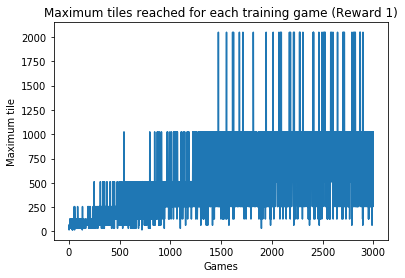

In [0]:
path = "/content/gdrive/My Drive/2048/"
suffix1 = "_reward1_run1.npy"
suffix2 = "_reward1_run2.npy"
scores_1 = np.concatenate((np.load(path+ "scores" + suffix1),np.load(path+ "scores" + suffix2)))
max_tiles_1 = np.concatenate((np.load(path+ "max_tiles" + suffix1),np.load(path+ "max_tiles" + suffix2)))
plt.plot(max_tiles_1)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 1)')
plt.show()

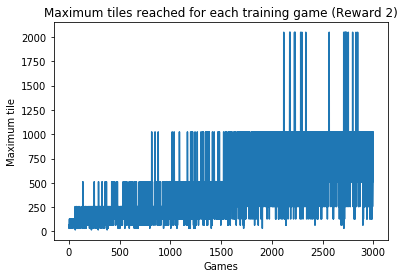

In [0]:
path = "/content/gdrive/My Drive/2048/"
suffix = "_reward3_run1.npy"
scores_3 = np.load(path+ "scores" + suffix)
max_tiles_3 = np.load(path+"max_tiles" + suffix)
plt.plot(max_tiles_3)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 2)')
plt.show()

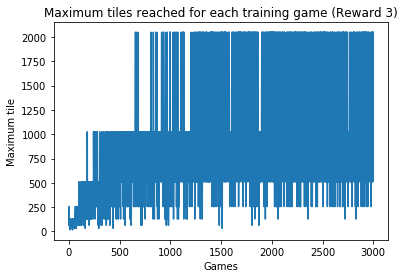

In [0]:
path = "/content/gdrive/My Drive/2048/"
suffix1 = "_reward4_run1.npy"
suffix2 = "_reward4_run3.npy"
scores_4 = np.concatenate((np.load(path+ "scores" + suffix1),np.load(path+ "scores" + suffix2)))
max_tiles_4 = np.concatenate((np.load(path+ "max_tiles" + suffix1),np.load(path+ "max_tiles" + suffix2)))
plt.plot(max_tiles_4)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 3)')
plt.show()

Text(0.5, 1.0, 'Reward training curve for reward 3 (moving average)')

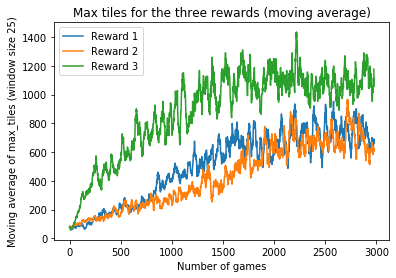

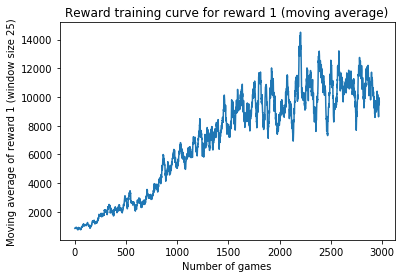

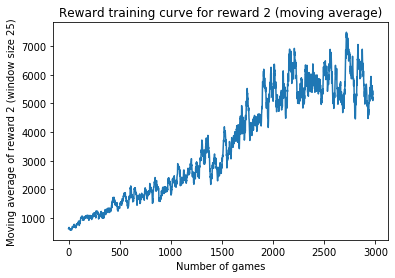

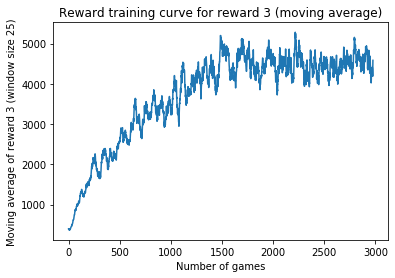

In [0]:
def moving_average(a, wind=25) :
    # Returns the moving average array associated to a with a window wind
    ret = np.cumsum(a, dtype=float)
    ret[wind:] = ret[wind:] - ret[:-wind]
    return ret[wind - 1:] / wind


plt.figure(0)
plt.xlabel('Number of games')
plt.ylabel('Moving average of max_tiles (window size 25)')
plt.plot(moving_average(max_tiles_1), label = 'Reward 1')
plt.plot(moving_average(max_tiles_3), label = 'Reward 2')
plt.plot(moving_average(max_tiles_4), label = 'Reward 3')
plt.legend(loc = 'best')

plt.title('Max tiles for the three rewards (moving average)')


plt.figure(1)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 1 (window size 25)')
plt.plot(moving_average(scores_1))
plt.title('Reward training curve for reward 1 (moving average)')

plt.figure(2)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 2 (window size 25)')
plt.plot(moving_average(scores_3))
plt.title('Reward training curve for reward 2 (moving average)')

plt.figure(3)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 3 (window size 25)')
plt.plot(moving_average(scores_4))
plt.title('Reward training curve for reward 3 (moving average)')

## **Testing results**

In [0]:
def play_game(env, QNetwork, render = True):
    ## Plays one unique game given an environment and a trained DQN
    state = env.reset()
    episode_reward = 0
    done = False
        
    while not done:
            
        x = change_values(state)
        x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
        output = QNetwork.forward(x) 
        for action in output.argsort()[0].cpu().numpy()[::-1]:
             next_state, reward, done, _ = env.step(action)
             if (state == next_state).all() == False:
                     break

            
        episode_reward += reward
        state = next_state
            
    if render:    
      env.render()         
      print( "Score: "+str(episode_reward))

    return(state)

def results(reward_mode):
    # Displays results (proportions of games reaching each existing level of max_tile) given a reward_mode
    if reward_mode == 'nb_merge_max_tile':
      reward_num = 3
      run = 1
    elif reward_mode == 'score':
      reward_num = 1
      run = 2
    elif reward_mode == 'nb_empty_tiles':
      reward_num = 4
      run = 3

    test_env = Env(reward_mode = reward_mode)

    path = "/content/gdrive/My Drive/2048/"
    QNetwork = DQN().to(device)
    filename = 'online_reward' + str(reward_num)+ '_run' + str(run)
    QNetwork.load_state_dict(torch.load(path + filename))
    
    dic_max = {}
    for i in range(13):
      dic_max[2**i]=0

    n_games = 1000

    for k in range(n_games):
      if (k%50 == 0):
        print(str(k) + " games played ")
      grid = play_game(test_env, QNetwork, render = False)
      max_tile = np.max(grid)
      dic_max[max_tile]=dic_max[max_tile]+1

    for key in dic_max:
      dic_max[key] = dic_max[key]/n_games

    return(dic_max)



In [0]:
results('nb_merge_max_tile')

/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.0,
 64: 0.009,
 128: 0.033,
 256: 0.144,
 512: 0.409,
 1024: 0.381,
 2048: 0.024,
 4096: 0.0}

In [0]:
results('score')

/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.0,
 64: 0.003,
 128: 0.029,
 256: 0.13,
 512: 0.339,
 1024: 0.454,
 2048: 0.045,
 4096: 0.0}

In [0]:
results('nb_empty_tiles')

0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.001,
 64: 0.002,
 128: 0.01,
 256: 0.039,
 512: 0.194,
 1024: 0.525,
 2048: 0.227,
 4096: 0.002}

# **Reproduce training results for each reward mode**

In [0]:
# This cell can reproduce the results obtained in the report: reward can be changed, n_epochs too (but will give different results if changed...)7
# For this number of epochs, run time is approximately 5 hours

def moving_average(a, wind=25) :
    # Returns the moving average array associated to a with a window wind
    ret = np.cumsum(a, dtype=float)
    ret[wind:] = ret[wind:] - ret[:-wind]
    return ret[wind - 1:] / wind

reward = 1          # Values can be 1,2 or 3
reward_mode = 'scores'*int(reward==1) + 'nb_merge_max_tile'*(int(reward == 2)) + 'nb_empty_tiles'*int(reward==3)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, reward_mode, None, None,None, None, None, cont = False, print_rate = 100)

plt.figure(0)
plt.plot(max_tiles)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward ' + str(reward) + ')' )
plt.show()

plt.figure(1)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward ' + str(reward) + ' (window size 25)')
plt.plot(moving_average(scores))
plt.title('Reward training curve for reward ' + str(reward) + ' (moving average)')

plt.figure(2)
plt.xlabel('Number of games')
plt.ylabel('Moving average of max_tiles for reward ' + str(reward) + ' (window size 25)')
plt.plot(moving_average(max_tiles))
plt.title('Max tiles for reward ' + str(reward) + ' (moving average)')

plt.show()

# **Reproduce testing results for each reward mode**

In [0]:
def play_game(env, QNetwork, render = True):
    ## Plays one unique game given an environment and a trained DQN
    state = env.reset()
    episode_reward = 0
    done = False
        
    while not done:
            
        x = change_values(state)
        x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
        output = QNetwork.forward(x) 
        for action in output.argsort()[0].cpu().numpy()[::-1]:
             next_state, reward, done, _ = env.step(action)
             if (state == next_state).all() == False:
                     break

            
        episode_reward += reward
        state = next_state
            
    if render:    
      env.render()         
      print( "Score: "+str(episode_reward))

    return(state)

def testing_results(reward):
  ## Returns test results given a reward (1,2 or 3)
    reward_mode = 'scores' * int(reward == 1) + 'nb_merge_max_tile' * int(reward == 2) + 'nb_empty_tiles' * int(reward == 3)
    test_env = Env(reward_mode=reward_mode)

    QNetwork = DQN().to(device)
    filename = 'parameters_reward_' + str(reward) + '.dms'
    QNetwork.load_state_dict(torch.load(filename))

    dic_max = {}
    for i in range(13):
        dic_max[2 ** i] = 0

    n_games = 1000

    for k in range(n_games):
        if (k % 50 == 0):
            print(str(k) + " games played ")
        grid = play_game(test_env, QNetwork, render=False)
        max_tile = np.max(grid)
        dic_max[max_tile] = dic_max[max_tile] + 1

    for key in dic_max:
        dic_max[key] = dic_max[key] / n_games

    return (dic_max)

testing_results(1) # Parameter can be from 1 to 3